In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
import polars as pl

from tqdm import tqdm
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=False)

from dataclasses import dataclass

plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True
                     })

In [2]:
# with uproot.open('/home/pgranger/atmospherics/sum_50k_hd_AV.root') as f:
file = '/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/flatcaf_sum.root'
def loadData(file):
    with uproot.open(file) as f:
        tree = f['cafTree']
        tree.show()
        cols = [key for key in tree.keys() if "Jagged" not in str(tree[key].interpretation)]

        data = f['cafTree'].arrays(cols, library='np')
        df = pl.from_pandas(pd.DataFrame(data))
        return df
    # print(df)

df = loadData(file)
dfold = loadData('/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV/caf_sum.root')

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
rec.CVNResult0Neu... | float                    | AsDtype('>f4')
rec.CVNResult0Pions  | float                    | AsDtype('>f4')
rec.CVNResult0Piz... | float                    | AsDtype('>f4')
rec.CVNResult0Pro... | float                    | AsDtype('>f4')
rec.CVNResult1Neu... | float                    | AsDtype('>f4')
rec.CVNResult1Pions  | float                    | AsDtype('>f4')
rec.CVNResult1Piz... | float                    | AsDtype('>f4')
rec.CVNResult1Pro... | float                    | AsDtype('>f4')
rec.CVNResult2Neu... | float                    | AsDtype('>f4')
rec.CVNResult2Pions  | float                    | AsDtype('>f4')
rec.CVNResult2Piz... | float                    | AsDtype('>f4')
rec.CVNResult2Pro... | float                    | AsDtype('>f4')
rec.CVNResultIsAn... | float                    | AsDtype(

In [5]:
pl.Config.set_tbl_rows(20)
@dataclass
class Flavour:
    pdg:int
    name:str
    name_latex:str
    cvn:str

flavours = {
    -16: Flavour(-16, "nutaubar", r"$\overline{\nu}_\tau$", "rec.cvnnutau"),
    -14: Flavour(-14, "numubar", r"$\overline{\nu}_\mu$", "rec.cvnnumu"),
    -12 : Flavour(-12, "nuebar", r"$\overline{\nu}_e$", "rec.cvnnue"),
    12: Flavour(12, "nue", r"$\nu_e$", "rec.cvnnue"),
    14: Flavour(14, "numu", r"$\nu_\mu$", "rec.cvnnumu"),
    16: Flavour(16, "nutau", r"$\nu_\tau$", "rec.cvnnutau")
}

def get_max():
    return  pl.max('rec.cvnnue','rec.cvnnumu','rec.cvnnutau','rec.cvnnc')

def define_flavour(df:pl.DataFrame):
    df = df.with_columns(
        Flavour = pl.when(get_max()==None).then(0).otherwise(
        pl.when((pl.col('rec.cvnnue') >= 0.85)).then(12).otherwise(
        pl.when(pl.col('rec.cvnnumu')>=0.5).then(14).otherwise(
        pl.when(pl.col('rec.cvnnc')>=0.8).then(0).otherwise(16)
        )))
    )
    return df

def fill_empty_categories(df, labels):

    empty_result = pl.DataFrame({ col: [0. for _ in labels] for col in df.columns })
    empty_result.with_columns(pl.Series(name='Ecut', values=labels))

    # works, but need to add manually.
    # empty_result = pl.DataFrame({'purity': 0., 'completeness': 0., 'total_events':0., 'Ecut': labels})
    empty_result = empty_result.with_columns(Ecut=pl.col('Ecut').cast(pl.Int16))

    out = pl.concat([empty_result,df],how='diagonal')
    out = out.groupby('Ecut').agg(
        pl.all().sum()
        # purity = pl.col("purity").sum(),
        # completeness = pl.col("completeness").sum(),
    ).sort('Ecut')
    return out

def eval_err(var:str):
    return pl.when(pl.col(var)!=0).then(1./pl.col(var).sqrt()).otherwise(1)

def eval_err_div(f:str, x:str, y:str, errx:str, erry:str):
    return pl.when(pl.col(x)!=0).then((pl.col(f)/pl.col(x)).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(
        pl.when(pl.col(y)>1).then((1./(pl.col(x) + pl.col(y))).pow(2)*((pl.col(y)*pl.col(errx)).pow(2) + (pl.col(x)*pl.col(erry)).pow(2)).sqrt()).otherwise(0.)
    )

shape: (34, 12)
┌──────┬───────────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬────────────┐
│ Ecut ┆ correct_p ┆ false_posi ┆ incorrect_ ┆ … ┆ err_false_ ┆ err_incorr ┆ errpurity ┆ errcomplet │
│ ---  ┆ dg        ┆ tive       ┆ pdg        ┆   ┆ positive   ┆ ect_pdg    ┆ ---       ┆ eness      │
│ i16  ┆ ---       ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ f64       ┆ ---        │
│      ┆ f64       ┆ f64        ┆ f64        ┆   ┆ f64        ┆ f64        ┆           ┆ f64        │
╞══════╪═══════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪════════════╡
│ 0    ┆ 352.0     ┆ 0.0        ┆ 1223.0     ┆ … ┆ 1.0        ┆ 0.028595   ┆ 0.002841  ┆ 0.000027   │
│ 1    ┆ 1186.0    ┆ 0.0        ┆ 1331.0     ┆ … ┆ 1.0        ┆ 0.02741    ┆ 0.000843  ┆ 0.000008   │
│ 2    ┆ 823.0     ┆ 1.0        ┆ 1039.0     ┆ … ┆ 1.0        ┆ 0.031024   ┆ 0.001212  ┆ 0.000013   │
│ 3    ┆ 452.0     ┆ 0.0        ┆ 761.0      ┆ … ┆ 1.0        ┆ 0.

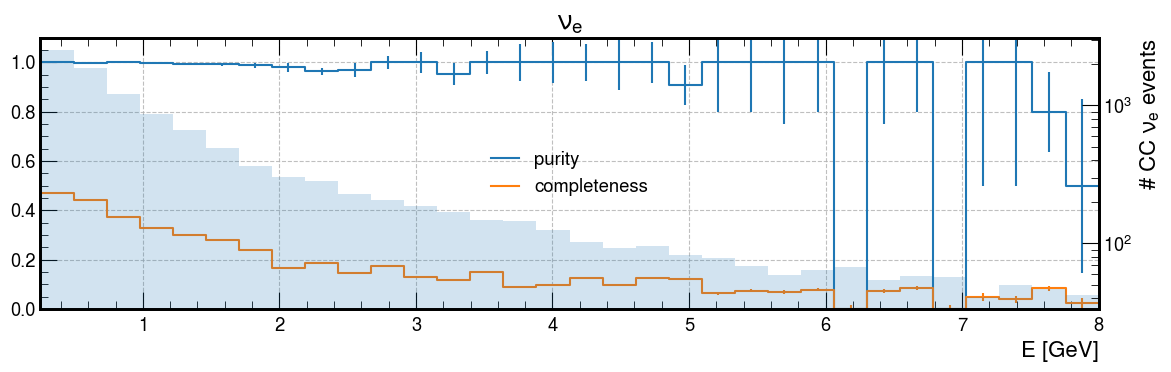

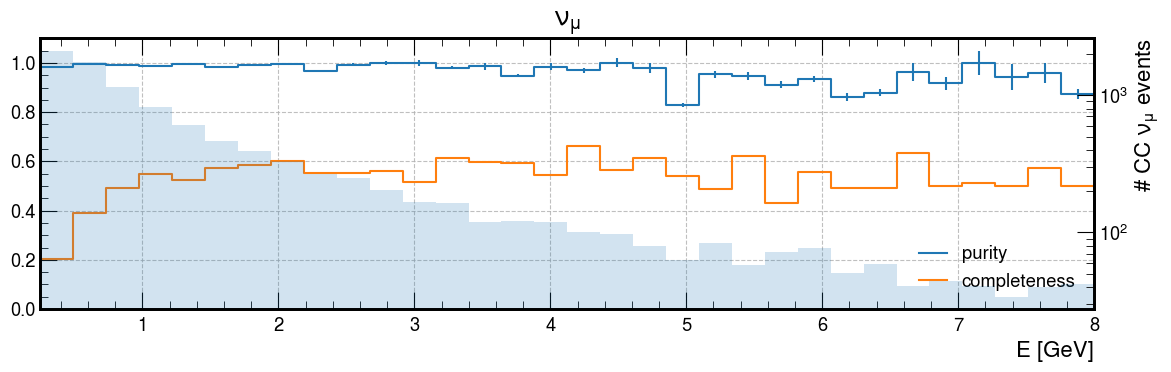

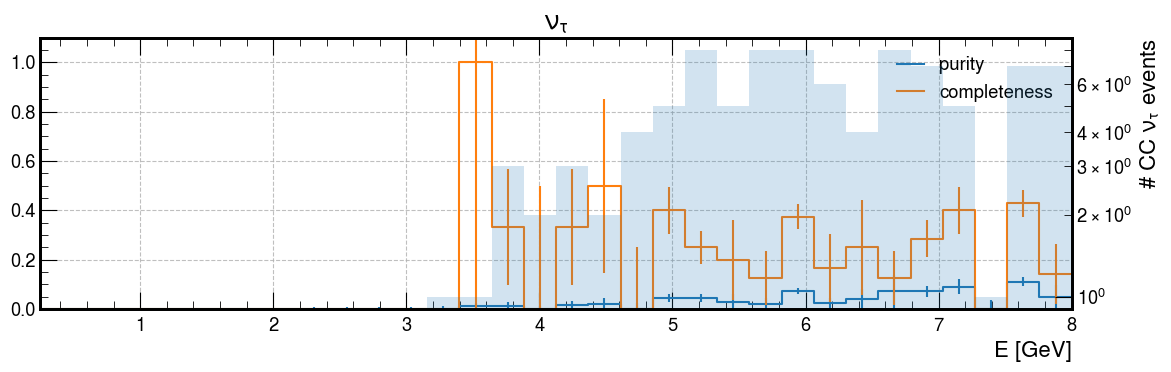

In [8]:
def purity_evolution(df, Ebins, flavour):
    labels = list(map(str, np.arange(0, len(Ebins) + 1)))
    # df = df.filter(
    #     pl.col('rec.NuMomZ')/(pl.col('rec.NuMomX').pow(2) + pl.col('rec.NuMomY').pow(2) + pl.col('rec.NuMomZ').pow(2)).sqrt() >0.7
    # )
    cats = df.with_columns(
        Ecut=df.get_column('rec.Ev').cut(Ebins, maintain_order=True, labels=labels).get_column('category').cast(pl.Int16),
        Ecutt=df.get_column('rec.Ev').cut(Ebins, maintain_order=True).get_column('category')
        )
        
    # print(cats.groupby('Ecutt').agg(pl.col('rec.Ev')).sort('Ecutt'))
    # print(df.get_column('rec.Ev').cut(Ebins, maintain_order=True, labels=labels).filter(pl.col('rec.Ev')<0.11))
    q = (
        cats.groupby('Ecut').agg(
            nb_above = pl.col('rec.pot').filter(pl.col(flavour.cvn) >= 0.5).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() == flavour.pdg).sum(),
            nb_other_above = pl.col('rec.pot').filter(pl.col(flavour.cvn) >= 0.5).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() != flavour.pdg).sum(),
            nb_below = pl.col('rec.pot').filter(pl.col(flavour.cvn) < 0.5).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() == flavour.pdg).sum(),
        ).fill_null(0).with_columns(
            err_nb_above = pl.col("nb_above").sqrt(),
            err_nb_other_above = pl.col("nb_other_above").sqrt(),
            err_nb_below = pl.col("nb_below").sqrt(),
            purity = pl.col('nb_above') /
            (pl.col('nb_other_above') + pl.col("nb_above")),
            completeness = pl.col('nb_above') /
            (pl.col('nb_below') + pl.col("nb_above")),
        ).sort('Ecut').select(
            pl.all(),
            errpurity = (pl.col('purity')/pl.col('nb_above')).pow(2)*((pl.col('nb_other_above')*pl.col('err_nb_above')).pow(2) + 
                                                                        (pl.col('nb_above')*pl.col('err_nb_other_above')).pow(2)).sqrt(),
            errcompleteness = (pl.col('completeness')/pl.col('nb_above')).pow(2)*((pl.col('nb_below')*pl.col('err_nb_above')).pow(2) + 
                                                                                    (pl.col('nb_above')*pl.col('err_nb_below')).pow(2)).sqrt(),
        )
    )
    q2 = (
        cats.groupby('Ecut').agg(
            correct_pdg = pl.col('rec.pot').filter(pl.col('Flavour') == flavour.pdg).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() == flavour.pdg).count().cast(pl.Float64),
            false_positive = pl.col('rec.pot').filter(pl.col('Flavour') == flavour.pdg).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() != flavour.pdg).count().cast(pl.Float64),
            incorrect_pdg = pl.col('rec.pot').filter(pl.col('Flavour') != flavour.pdg).filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() == flavour.pdg).count().cast(pl.Float64),
            total_events = pl.col('rec.pot').filter(
                pl.col("rec.isCC") == 1).filter(pl.col('rec.nuPDG').abs() == flavour.pdg).count().cast(pl.Float64)

        ).fill_null(0).with_columns(
            purity = pl.col('correct_pdg')/
            (pl.col('correct_pdg') + pl.col("false_positive")),
            completeness = pl.col('correct_pdg') /
            (pl.col('correct_pdg') + pl.col("incorrect_pdg")),
        ).fill_nan(0).with_columns(
            err_correct_pdg = eval_err('correct_pdg'),
            err_false_positive = eval_err('false_positive'),
            err_incorrect_pdg = eval_err('incorrect_pdg'),
        ).sort('Ecut').select(
            pl.all(),
            errpurity = eval_err_div('purity','correct_pdg','false_positive','err_correct_pdg','err_false_positive'),
            errcompleteness  = eval_err_div('completeness','correct_pdg','incorrect_pdg','err_correct_pdg','err_incorrect_pdg'),
        )
    )
    # bins_center = (Ebins[1:] + Ebins[:-1])*0.5
    bins_center = Ebins
    bins_width = np.diff(Ebins)
    q = fill_empty_categories(q, labels)
    q2 = fill_empty_categories(q2, labels)
    fig = plt.figure(figsize=(12,4))
    print(q2)
    p = plt.step(bins_center, q2.get_column('purity')[:-1], label='purity')
    # plt.step(bins_center, q.get_column('purity')[:-1], label='purity0')
    c = plt.step(bins_center, q2.get_column('completeness')[:-1], label='completeness')
    # plt.step(bins_center, q.get_column('completeness')[:-1], label='completeness0')

    error_center = (bins_center[1:] + bins_center[:-1])/2
    point_purity = q2.get_column('purity')[1:-1]
    err_purity = q2.get_column('errpurity')[1:-1]
    point_completeness = q2.get_column('completeness')[1:-1]
    err_completeness = q2.get_column('errcompleteness')[1:-1]
    plt.errorbar(error_center, point_purity,ls='none', marker='none', yerr=err_purity, color=p[0].get_color())
    plt.errorbar(error_center, point_completeness,ls='none', marker='none', yerr=err_completeness, color=c[0].get_color())
    plt.title(flavour.name_latex)
    plt.xlabel("E [GeV]")
    plt.xlim(bins_center[0], bins_center[-1])
    plt.ylim(0,1.1)
    plt.legend()
    # plt.xscale('log')
    ax2 = plt.twinx()

    ax2.bar(bins_center[:-1], q2.get_column('total_events')[1:-1], width=bins_width, align="edge", alpha=0.2, log=True)
    ax2.set_ylabel(rf'# CC {flavour.name_latex} events')
    ax2.grid(False)
    # return fig

# Ebins = np.logspace(-1,2, 10)
Ebins = np.linspace(0.25,8,33)
df = define_flavour(df)
dfold = define_flavour(dfold)
purity_evolution(df, Ebins, flavours[12]);
purity_evolution(df, Ebins, flavours[14]);
purity_evolution(df, Ebins, flavours[16]);

In [ ]:

# bins = np.linspace(0, 1, 100)

# fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# for f in flavours[3:]:
#     selection = df.filter(np.abs(pl.col("rec.nuPDG")) == f.pdg).filter(pl.col('rec.isCC') == 1).filter(pl.col('rec.Ev') > 3.5)
#     ax.hist(selection['rec.cvnnumu'], bins=bins, label=f.name_latex, histtype='step', weights=np.ones_like(selection['rec.cvnnumu'])*selection['rec.pot']/len(selection['rec.cvnnumu']), density=True)
# selection = df.filter(pl.col('rec.isCC') == 0).filter(pl.col('rec.Ev') > 3.5)
# ax.hist(selection['rec.cvnnumu'], bins=bins, label='NC', histtype='step', weights=np.ones_like(selection['rec.cvnnumu'])*selection['rec.pot']/len(selection['rec.cvnnumu']), density=True)


# plt.legend()
# plt.xlabel("CVN score")
# plt.ylabel("Event distribution (a.u)")
# plt.yscale('log')
# plt.title("CVN numu")

# fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# for f in flavours[3:]:
#     selection = df.filter(np.abs(pl.col("rec.nuPDG")) == f.pdg).filter(pl.col('rec.isCC') == 1).filter(pl.col('rec.Ev') > 3.5)
#     ax.hist(selection['rec.cvnnue'], bins=bins, label=f.name_latex, histtype='step', weights=np.ones_like(selection['rec.cvnnue'])*selection['rec.pot']/len(selection['rec.cvnnue']), density=True)
# selection = df.filter(pl.col('rec.isCC') == 0).filter(pl.col('rec.Ev') > 3.5)
# ax.hist(selection['rec.cvnnue'], bins=bins, label='NC', histtype='step', weights=np.ones_like(selection['rec.cvnnue'])*selection['rec.pot']/len(selection['rec.cvnnue']), density=True)
# plt.legend()
# plt.xlabel("CVN score")
# plt.ylabel("Event distribution (a.u)")
# plt.yscale('log')
# plt.title("CVN nue")

# fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# for f in flavours[3:]:
#     selection = df.filter(np.abs(pl.col("rec.nuPDG")) == f.pdg).filter(pl.col('rec.isCC') == 1).filter(pl.col('rec.Ev') > 3.5)
#     ax.hist(selection['rec.cvnnutau'], bins=bins, label=f.name_latex, histtype='step', weights=np.ones_like(selection['rec.cvnnutau'])*selection['rec.pot']/len(selection['rec.cvnnutau']), density=True)
# selection = df.filter(pl.col('rec.isCC') == 0).filter(pl.col('rec.Ev') > 3.5)
# ax.hist(selection['rec.cvnnutau'], bins=bins, label='NC', histtype='step', weights=np.ones_like(selection['rec.cvnnutau'])*selection['rec.pot']/len(selection['rec.cvnnutau']), density=True)
# plt.legend()
# plt.xlabel("CVN score")
# plt.ylabel("Event distribution (a.u)")
# plt.yscale('log')
# plt.title("CVN nutau")


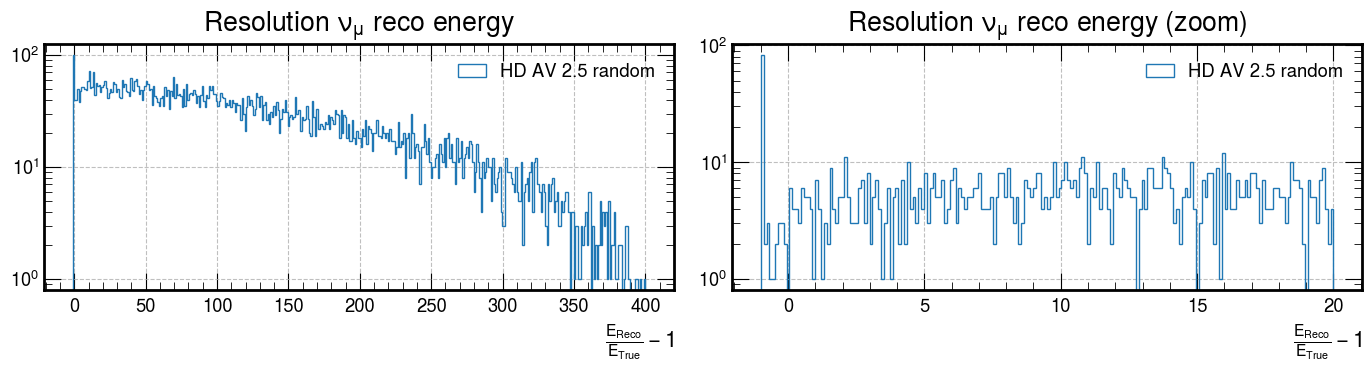

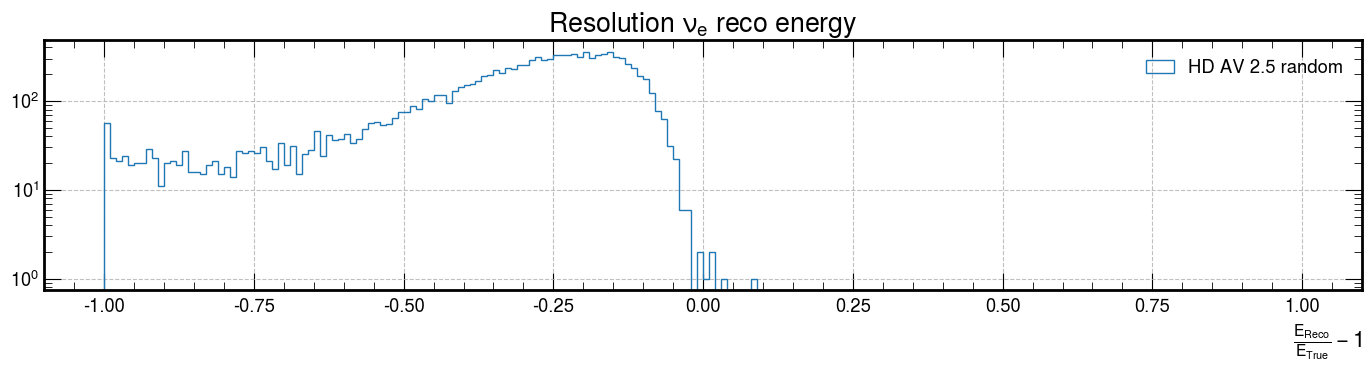

In [12]:
len_cm = [9.833E-1, 1.786E0, 3.321E0, 6.598E0, 1.058E1,
          3.084E1, 4.250E1, 6.732E1, 1.063E2, 1.725E2,
          2.385E2, 4.934E2, 6.163E2, 8.552E2, 1.202E3,
          1.758E3, 2.297E3, 4.359E3, 5.354E3, 7.298E3, 1.013E4, 1.469E4, 1.910E4, 3.558E4, 4.326E4, 5.768E4, 7.734E4, 1.060E5, 1.307E5]
 
KE_MeV = [10, 14, 20, 30, 40, 80, 100, 140, 200, 300, 400, 800, 1000, 1400, 2000, 3000,
          4000, 8000, 10000, 14000, 20000, 30000, 40000, 80000, 100000, 140000,
          200000, 300000, 400000]
from scipy.interpolate import CubicSpline
spl = CubicSpline(len_cm,KE_MeV)

def flavour(pdg):
    return pl.col('rec.nuPDG') == pdg
    # return pl.col('Flavour') == pdg

def energy(pdg):
    En = 'Ev'
    # return (pl.col(En) >=1 ) & (pl.col(En) <= 10)
    return (pl.col(En) >=0 )
def checkEnergy(df):
    E = df.with_columns(
        lep_range_cm = (pl.col('rec.RecoLepEnNumu').pow(2) - 0.105*0.105).sqrt()

    ).with_columns(
        Ev = pl.col('rec.Ev'),
        Ev_reco = pl.col('rec.Ev_reco'),
        Ev_reco_nue = pl.col('rec.Ev_reco_nue'),
        Ev_reco_numu = pl.col('rec.Ev_reco_numu'),
        Ev_reco_numu_h = ((pl.col('lep_range_cm').apply(lambda x: spl(x)/1000).pow(2) + 0.105*0.105)).sqrt()+pl.col('rec.RecoHadEnNumu'),
        LepE_h = ((pl.col('lep_range_cm').apply(lambda x: spl(x)/1000).pow(2) + 0.105*0.105)).sqrt()
    ).with_columns(
        Eres = pl.col("Ev_reco")/pl.col("Ev") - 1,
        Eres_nue = pl.col("Ev_reco_nue")/pl.col("Ev") - 1,
        Eres_numu = pl.col("Ev_reco_numu")/pl.col("Ev") - 1,
    )
    return E
E = checkEnergy(df)
Eold = checkEnergy(dfold)
fig, axs = plt.subplots(1,2,figsize=(14,4))
binsmu = 400
binsmu_z = 200
binse = 200

limmu = 400
limmu_z = 20
lime = 1
ax = axs[0]
ax.hist(E.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=binsmu, range=(-1,limmu), log=True, histtype='step', label='HD AV 2.5 random');
# ax.hist(Eold.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=400, range=(-1,limmu), log=True, histtype='step', label='HD AV');
ax.set_title(r'Resolution $\nu_\mu$ reco energy')
ax.set_xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
ax.legend()
ax = axs[1]
ax.hist(E.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=binsmu_z, range=(-1,limmu_z), log=True, histtype='step', label='HD AV 2.5 random');
# ax.hist(Eold.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))['Eres_numu'], bins=200, range=(-1,limmu_z), log=True, histtype='step', label='HD AV');
ax.set_title(r'Resolution $\nu_\mu$ reco energy (zoom)')
ax.set_xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
ax.legend()
plt.figure(figsize=(14,4))
plt.hist(E.filter(flavour(12)).filter(pl.col('rec.isCC')==1).filter(energy(12))['Eres_nue'], bins=binse, range=(-1, lime),log=True, histtype='step', label='HD AV 2.5 random');
# plt.hist(Eold.filter(flavour(12)).filter(pl.col('rec.isCC')==1).filter(energy(12))['Eres_nue'], bins=200, range=(-1, lime),log=True, histtype='step', label='HD AV');
plt.title(r'Resolution $\nu_e$ reco energy')
plt.xlabel(r'$\frac{E_{Reco}}{E_{True}} - 1$')
plt.legend()

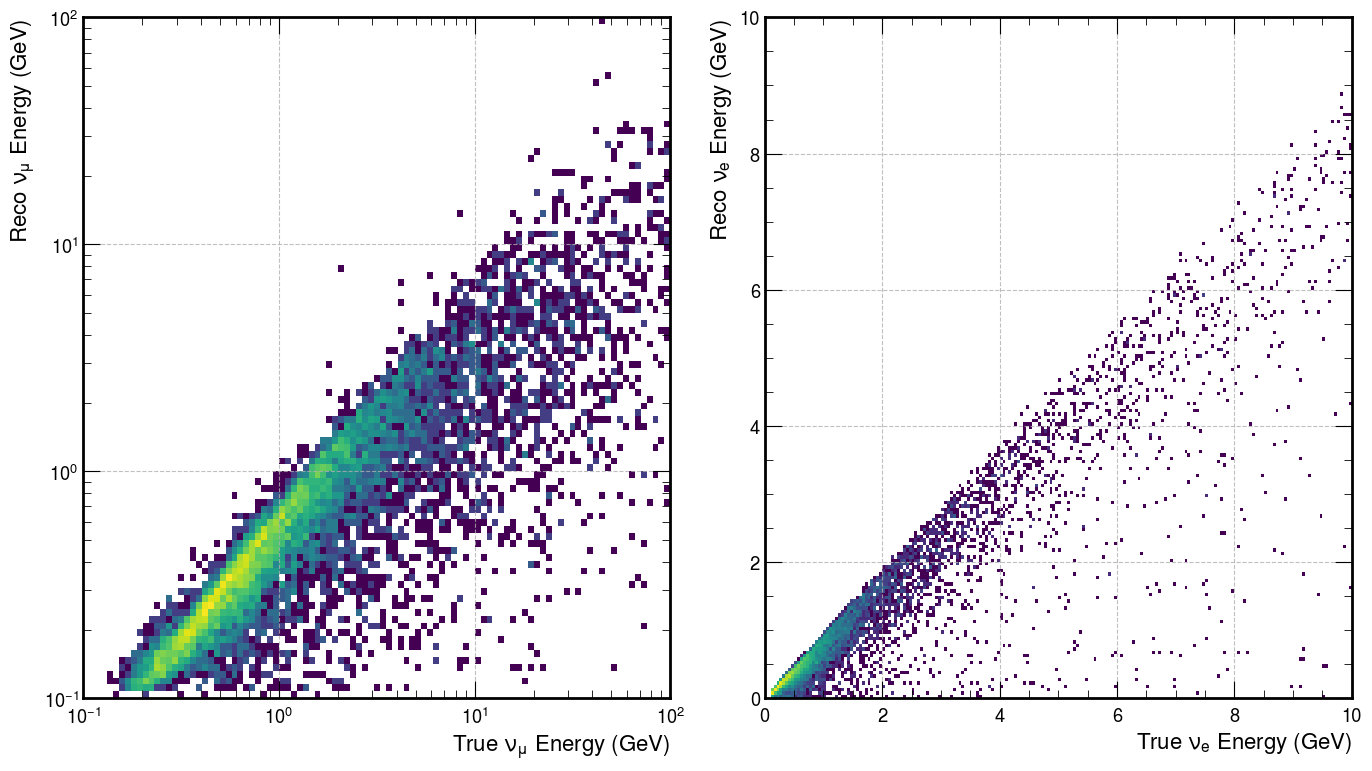

In [17]:

E = checkEnergy(df)
Eold = checkEnergy(dfold)
Emu = E.filter(flavour(14)).filter(pl.col('rec.isCC')==1).filter(energy(14))
Ee = E.filter(flavour(12)).filter(pl.col('rec.isCC')==1).filter(energy(12))
ax:plt.Axes
binsx = np.logspace(-1,np.log10(100),100)
binsy = np.logspace(-1,np.log10(100),100)
# binsx = np.linspace(0.1,20,200)
# binsy = np.linspace(0.1,20,200)
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].hist2d(Emu['Ev'], Emu['Ev_reco_numu_h'], bins=(binsx,binsy), range=((0,10),(0,10)), norm = LogNorm())
ax[0].set_xlabel(rf'True {flavours[14].name_latex} Energy (GeV)')
ax[0].set_ylabel(rf'Reco {flavours[14].name_latex} Energy (GeV)')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].hist2d(Ee['Ev'], Ee['Ev_reco_nue'], bins=(200,200), range=((0,10),(0,10)), norm = LogNorm());
ax[1].set_xlabel(rf'True {flavours[12].name_latex} Energy (GeV)')
ax[1].set_ylabel(rf'Reco {flavours[12].name_latex} Energy (GeV)')
plt.show()

In [44]:
dftest = dfold.filter((pl.col('rec.Ev')>2) & (pl.col('rec.Ev')<5)).filter(pl.col("rec.isCC")==1)

# dftest = dftest.filter(
#     pl.col('rec.NuMomZ')/(pl.col('rec.NuMomX').pow(2) + pl.col('rec.NuMomY').pow(2) + pl.col('rec.NuMomZ').pow(2)).sqrt() >0.7
# )
nutotal = len(dftest)
print(f'Total # of events: {nutotal}, which CC: {len(dftest.filter(pl.col("rec.isCC")==1))}')
nue = len(dftest.filter(pl.col("rec.nuPDG").abs() == 12))
numu = len(dftest.filter(pl.col("rec.nuPDG").abs() == 14))
nuereco = len(dftest.filter(pl.col('Flavour')==12))
numureco = len(dftest.filter(pl.col('Flavour')==14))
# nutau = len(dftest.filter(pl.col('Flavour')==16))
nunot = len(dftest.filter(pl.col('Flavour')==0))
print(f'Nue events: {nue*100/nutotal:.2f}%, Reconstructed nue: {nuereco*100/nue:.2f}%')
print(f'Numu events: {numu*100/nutotal:.2f}%, Reconstructed numu: {numureco*100/numu:.2f}%')
# print(f'Reco middle: {nutau*100/nutotal:.2f}%')
print(f'Fail reco: {nunot*100/nutotal:.2f}%')
print(f'Nue or Numu reco: {(nuereco+numureco)*100/nutotal:.2f} %')

Total # of events: 2056, which CC: 2056
Nue events: 51.12%, Reconstructed nue: 45.77%
Numu events: 48.54%, Reconstructed numu: 64.63%
Fail reco: 41.54%
Nue or Numu reco: 54.77 %


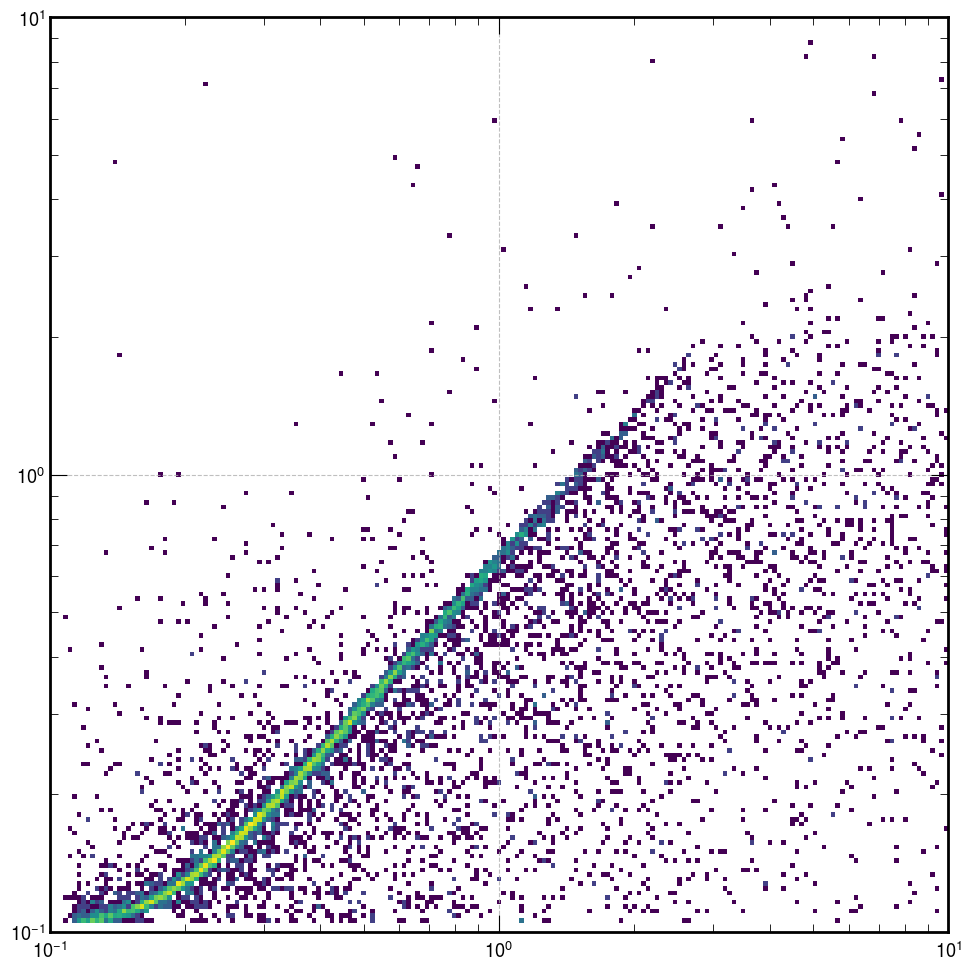